In [2]:
# Packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
from re import findall
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
mycolors = {"blue": "steelblue", "red":"#a76c6e", "green":"#6a9373", "smoke": "#f2f2f2"}

# Tensorflow
import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa
from tensorflow.keras.layers import TextVectorization
# import tensorflow_io as tfio

In [3]:
tf.config.list_logical_devices('GPU')

[LogicalDevice(name='/device:GPU:0', device_type='GPU')]

In [ ]:
# Setting for matplotlib plots
# plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = 10, 6

## EDA

### Load

In [4]:
file_paths = [i.as_posix() for i in (Path.home() /'Desktop/RNN/nlp_getting_started').glob('*.csv')]
file_paths.sort()
file_paths

['C:/Users/ordin/Desktop/RNN/nlp_getting_started/sample_submission.csv',
 'C:/Users/ordin/Desktop/RNN/nlp_getting_started/test.csv',
 'C:/Users/ordin/Desktop/RNN/nlp_getting_started/train.csv']

In [5]:
# Read data
df_test = pd.read_csv(file_paths[1])
df_train = pd.read_csv(file_paths[2])
print(f"Training data shape: {df_train.shape}")
print(f"Test data shape: {df_test.shape}")

Training data shape: (7613, 5)
Test data shape: (3263, 4)


In [ ]:
# Randomly choose five tweets
for i in np.random.choice(df_train.query("target == 1").index, 5):
    print(f"Tweet {i} | target {df_train.target[i]}: {df_train.text[i]}")
print()
for i in np.random.choice(df_train.query("target == 0").index, 5):
    print(f"Tweet {i} | target {df_train.target[i]}: {df_train.text[i]}")

Tweet 3040 | target 1: #USGS M 0.9 - Northern California: Time2015-08-06 01:50:25 UTC2015-08-06 01:50:25 UTC at epicenter... http://t.co/mBo6OAnIQI #EarthTwerk
Tweet 1751 | target 1: Baltimore City : I-95 NORTH AT MP 54.8 (FORT MCHENRY TUNNEL BORE 3: Collision: I-95 NORTH AT MP 54.8 (FORT MCHENRY TUNNEL BORE 3 Nort...
Tweet 5282 | target 1: Families to sue over Legionnaires: More than 40 families affected by the fatal outbreak of Legionnaires' disea... http://t.co/8lCbDW7m2z
Tweet 2827 | target 1: At least 180 dead a million displaced in India floods - India | ReliefWeb http://t.co/0abgFgLH7X
Tweet 5031 | target 1: @Lolly_Knickers It's a mudslide. 
It's like chewing on a rubber tyre.
And with those I'm DONE.
#vaginaorcake #GBBO

Tweet 3813 | target 0: Loved the way this book was written to include so many vantage points of First Responders @DetKenLang #kindle http://t.co/KcRnMJKJ73
Tweet 2020 | target 0: lmao fuckboy changed his @ for damage control
@Pseudojuuzo
Tweet 5549 | target 0: 

In [5]:
# Data preview
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [5]:
# Data preview
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [239]:
# Data preview
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [240]:
# Data preview
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


### Target distribution

* The test data is what we need to predict if there is real disater happening for Kaggle competition, so it doesn't contain `target` column. Let's see the distribution of the true targets in training data.

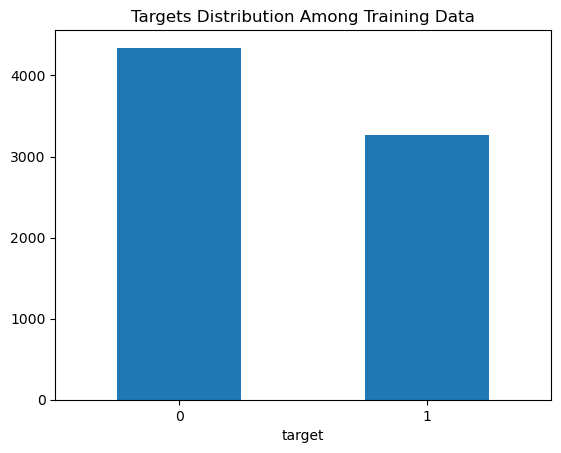

In [ ]:
# Targets distribution among training data
df_train['target'].value_counts().plot(kind = 'bar', title = 'Targets distribution among training data'.title(), rot = 0);

### Missing value

* From the data info we can see that there are missing values among some columns. Let's compute the exact number of them in training and test dataset.

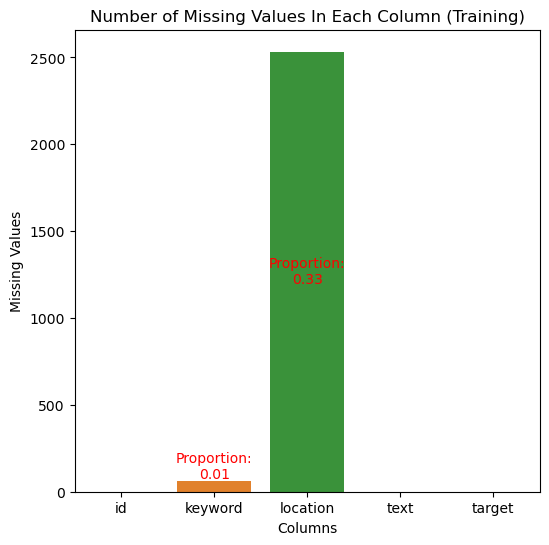

In [275]:
# Missing values (training data)
fig, ax = plt.subplots(figsize=(6, 6))
data = pd.DataFrame(np.sum(df_train.isna(), axis=0)).reset_index()
data.columns = ['Columns', 'Missing Values']
# Count the proportion of missing values
data['percentage'] = data['Missing Values'].apply(lambda x: np.round(x/len(df_train), 2))
sns.barplot(data=data, x='Columns', y='Missing Values', hue='Columns', ax=ax)
# Add annotation
ax.bar_label(ax.containers[1], fmt=f'Proportion:\n{data["percentage"][1]}', label_type='edge', color='red')
ax.bar_label(ax.containers[2], fmt=f'Proportion:\n{data["percentage"][2]}', label_type='center', color='red')
ax.set_title('Number of Missing Values In Each Column (Training)');

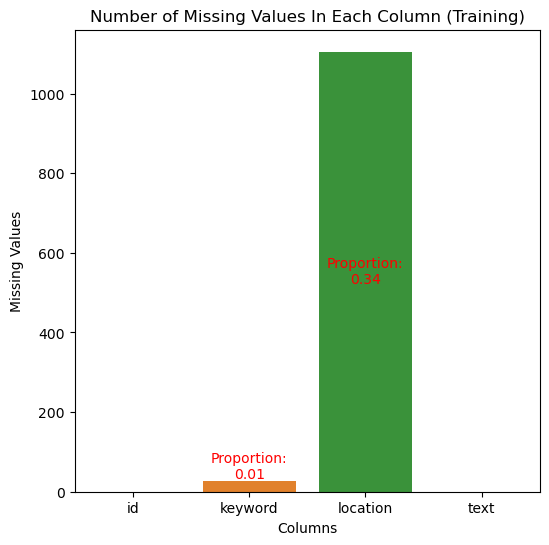

In [277]:
# Missing values (test data)
fig, ax = plt.subplots(figsize=(6, 6))
data = pd.DataFrame(np.sum(df_test.isna(), axis=0)).reset_index()
data.columns = ['Columns', 'Missing Values']
# Count the proportion of missing values
data['percentage'] = data['Missing Values'].apply(lambda x: np.round(x/len(df_test), 2))
sns.barplot(data=data, x='Columns', y='Missing Values', hue='Columns', ax=ax)
# Add annotation
ax.bar_label(ax.containers[1], fmt=f'Proportion:\n{data["percentage"][1]}', label_type='edge', color='red')
ax.bar_label(ax.containers[2], fmt=f'Proportion:\n{data["percentage"][2]}', label_type='center', color='red')
ax.set_title('Number of Missing Values In Each Column (Training)');

### Keyword

* Both training and test data contain almost the same proportion of missing values. Comparing to the column, `location`, the missing values in `keyword` column is much fewer. We can explore deeper to see if it provides useful information.

In [282]:
# Unique values
print(f'Number of unique values in keyword = {df_train["keyword"].nunique()} (Training) | {df_test["keyword"].nunique()} (Test)')

Number of unique values in keyword = 221 (Training) | 221 (Test)


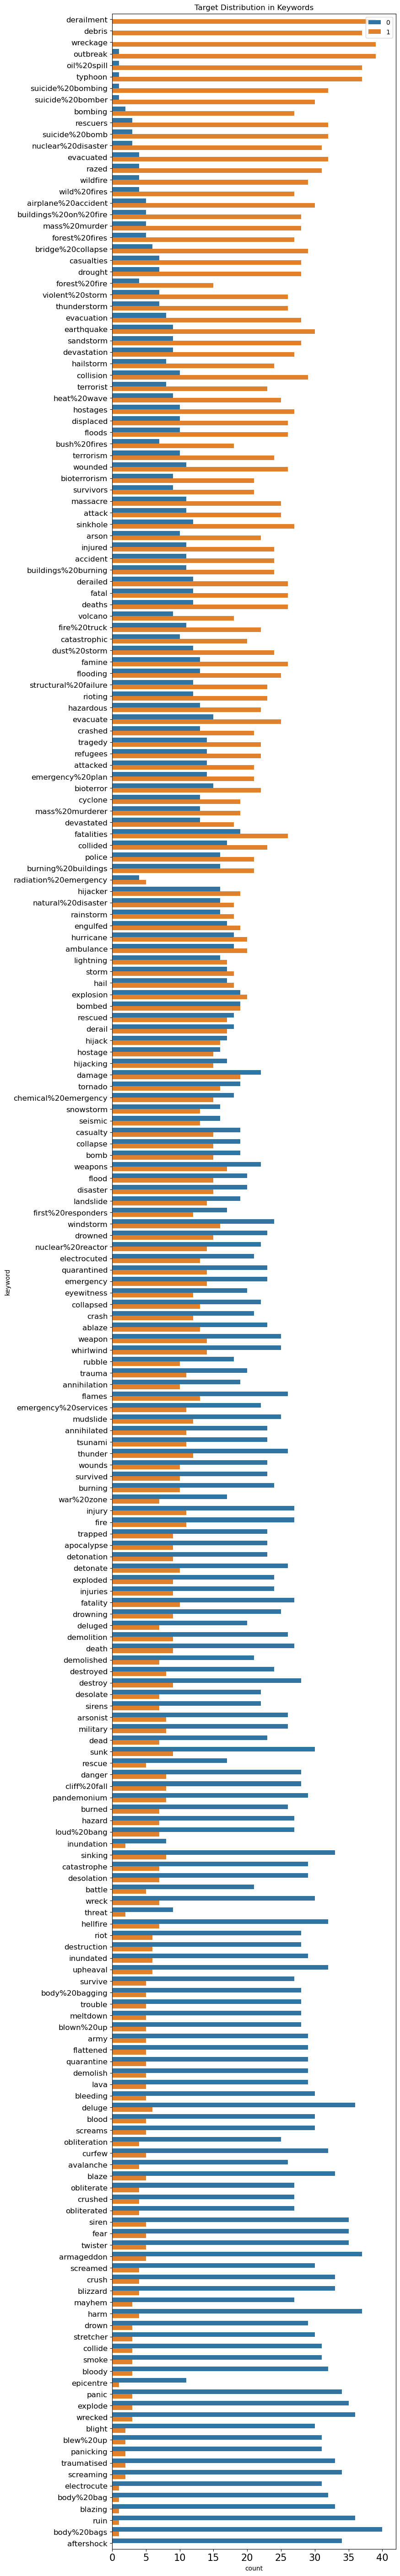

In [283]:
df_train['target_mean'] = df_train.groupby('keyword')['target'].transform('mean')
fig = plt.figure(figsize=(8, 72), dpi=100)

sns.countplot(
    y=df_train.sort_values(by='target_mean', ascending=False)['keyword'],
    hue=df_train.sort_values(by='target_mean', ascending=False)['target'])

plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=12)
plt.legend(loc=1)
plt.title('Target Distribution in Keywords')

plt.show()

df_train.drop(columns=['target_mean'], inplace=True)

In [12]:
data.index

Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')

### Tweet EDA and process

In [ ]:
# EDA and preprocessing
import re
# Functions for tokenization
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Modeling
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF
from sklearn.metrics import accuracy_score
import sklearn.metrics as metrics
import itertools
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

In [15]:
df_train.columns

Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')

In [ ]:
# Number of news in each category: 
print("Number of news in each category (Training data): ")
print(df_train.groupby('category').size())

In [17]:
df_train['location'].duplicated().sum()

4271

In [19]:
# Number of tweets in each category: 
print("Number of tweets in each location (Training data): ")
print(df_train.groupby('location').size())

Number of tweets in each location (Training data): 
location
                          1
  Glasgow                 1
  Melbourne, Australia    1
  News                    1
  å_                      1
                         ..
å_: ?? ÌÑ ? : ?           1
å_å_Los Mina Cityã¢      1
å¡å¡Midwest Û¢Û¢        1
åÊ(?Û¢`?Û¢å«)??         1
åø\_(?)_/åø               1
Length: 3341, dtype: int64


In [14]:
# Number of tweets in each category: 
print("Number of tweets in each location (Training data): ")
print(df_train.groupby('keyword').size())

Number of tweets in each location (Training data): 
keyword
ablaze                 36
accident               35
aftershock             34
airplane%20accident    35
ambulance              38
                       ..
wounded                37
wounds                 33
wreck                  37
wreckage               39
wrecked                39
Length: 221, dtype: int64


In [25]:
df_train['location'].dropna().duplicated().sum()

1739

In [16]:
df_train['keyword'].dropna().duplicated().sum()

7331

In [27]:
loc_clean = df_train['location'].dropna().apply(lambda x: ''.join(letter for letter in x if letter.isalnum()))
# print(test_str))

In [33]:
type(loc_clean)

pandas.core.series.Series

In [35]:
for i in loc_clean:
    print(i)

Birmingham
EstSeptember2012Bristol
AFRICA
PhiladelphiaPA
LondonUK
Pretoria
WorldWide
ParanaqueCity
LiveOnWebcam
milkyway
GREENSBORONORTHCAROLINA
LiveOnWebcam
England
SheffieldTownshipOhio
India
Barbados
Anaheim
Abuja
USA
SouthAfrica
SaoPauloBrazil
hollywoodland
EdmontonAlbertaTreaty6
InangPamantasan
TwitterLockoutinprogress
ConcordCA
CalgaryAB
Birmingham
SanFrancisco
CLVLND
NashvilleTN
SantaClaraCA
UK
StLouisMO
WalkerCountyAlabama
Australia
NorthCarolina
NorfCarolina
SanMateoCountyCA
NorthCarolina
NjoroKenya
YourSistersBedroom
ArlingtonTX
SouthBloomfieldOH
NewHanoverCountyNC
Maldives
ManchesterNH
WilmingtonNC
NewHanoverCountyNC
global
AlbertaSaskMontana
Charlotte
BatonRougeLA
HagerstownMD
GloucestershireUK
UK
NairobiKenya
Instagramheyimginog
304
Switzerland
304
US
304
Instagramheyimginog
304
SomewhereOnlyWeKnow
Belgium
Switzerland
US
dopeshow
Switzerland
Switzerland
OshawaCanada
BakerCityOregon
UnitedStates
304
304
marysvilleca
304
HermosaBeachCA
304
304
1960085899047821
Pennsylvania
S

In [31]:
loc_clean.shape

(5080,)

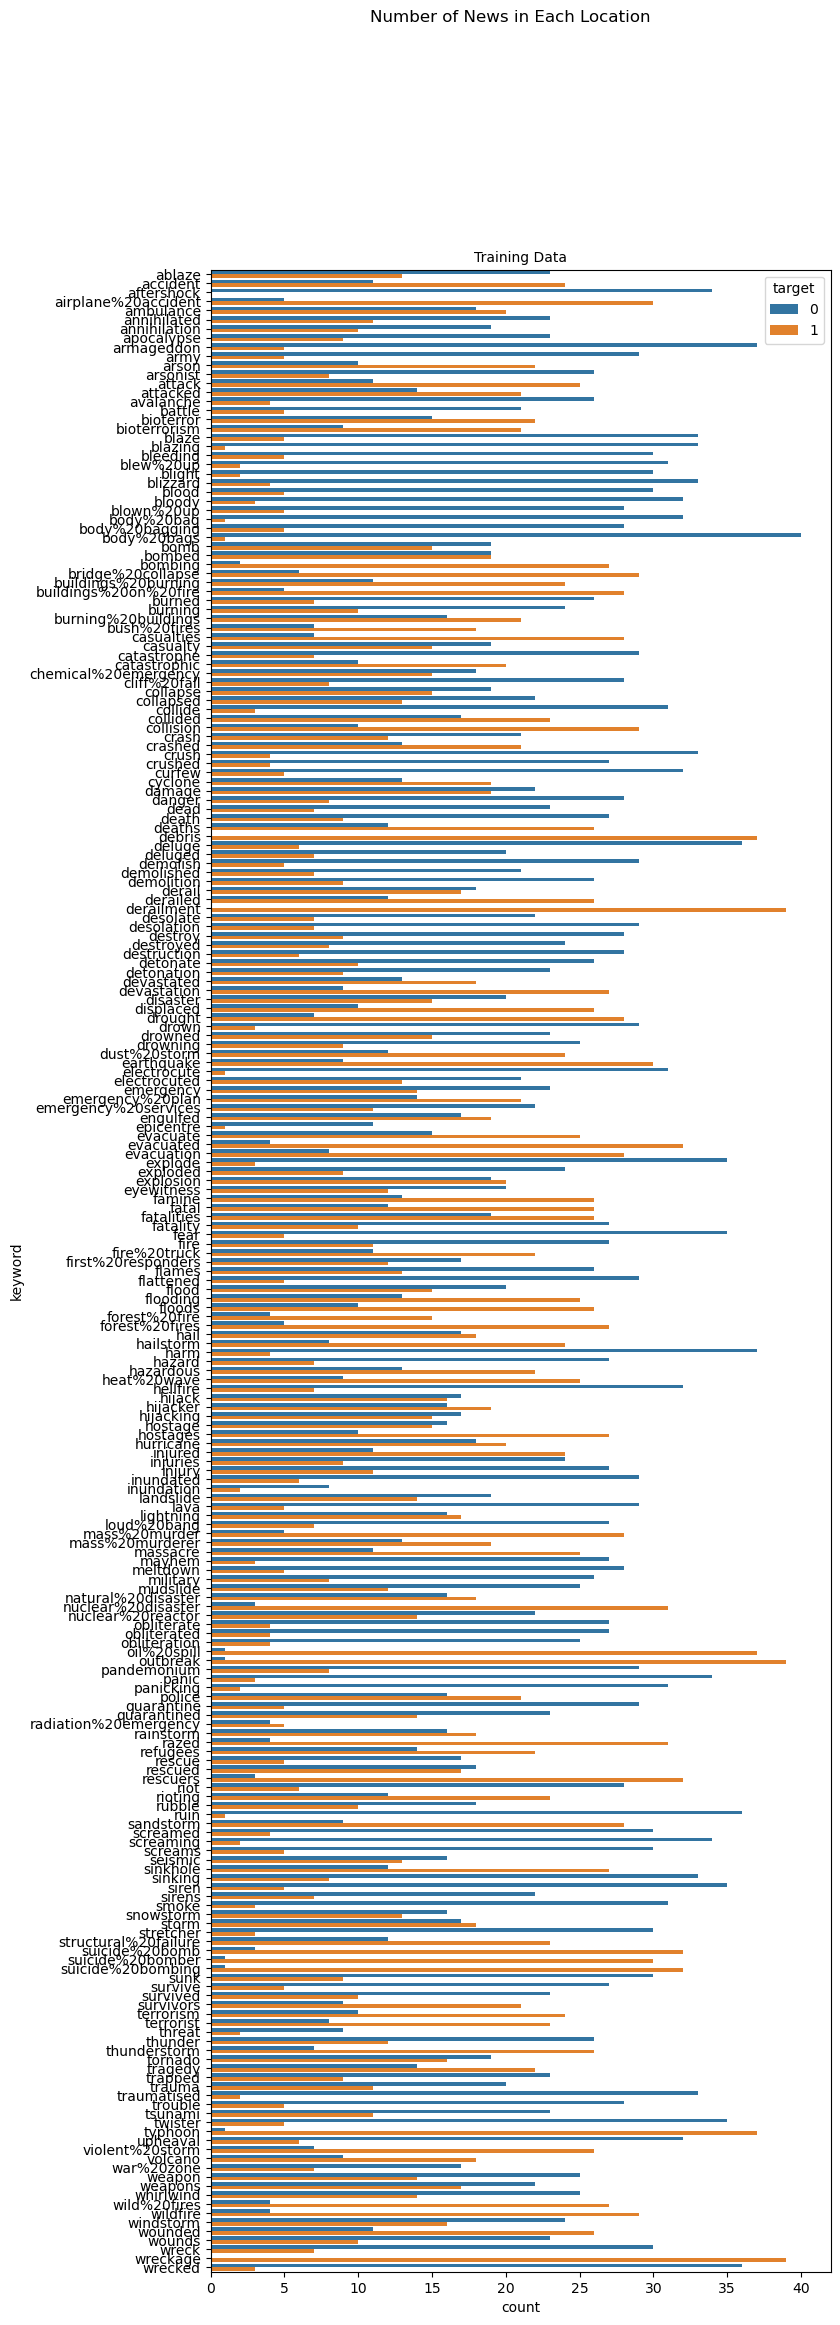

In [280]:
# Plot: Number of news in each category
fig, ax = plt.subplots(figsize = (8, 26))

sns.countplot(y = 'keyword', data = df_train, hue='target', ax = ax)
fig.suptitle('Number of News in Each Location')
ax.set_title('Training Data', fontdict = dict(size = 10));

### Apply NLP

In [6]:
# Import needed package,
from nltk.corpus import stopwords
stopwords_en = stopwords.words('english')
from string import punctuation
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize


# Initialize a lemmatizer
wnl = WordNetLemmatizer()

# Function for converting Penn Treebank tags in order to fit the format WordNet Lemmatizer
def penn2morphy(penntag):
    morphy_tag = {'NN':'n', 'JJ':'a', 'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n' # if mapping isn't found, fall back to Noun.

# Function for preprocessing
def preprocessing(text):

    # Get word tokens
    word_tokens = word_tokenize(text)
    
    # Remove stop words and lowercasing
    stopwords_removed_lower_text = [word.lower() for word in word_tokens if word not in stopwords_en]
    
    # We can utilize set operation to remove punctuations in the previous cleaned text
    punc_stopwords_removed_lower_text = list(set(stopwords_removed_lower_text) - set(punctuation))

    # With tagging, we can utilize the lemmatize()
    preprocessed_text = [wnl.lemmatize(word, pos=penn2morphy(tag)) for word, tag in pos_tag(punc_stopwords_removed_lower_text)]

    # Raw documents format for TF-IDF
    preprocessed_text = " ".join(preprocessed_text)

    return preprocessed_text

In [7]:
# Apply the function to the dataset and create a new column to store the results
df_train['cleaned_tweet'] = df_train['text'].apply(lambda text: preprocessing(text))
df_train['number_of_words'] = df_train['cleaned_tweet'].apply(lambda text: len(text.split()))
# See the results
df_train.head()

,id,keyword,location,text,target,cleaned_tweet,number_of_words
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,allah forgive our deed u may earthquake reason,8
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,canada ronge sask near forest la fire,7
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,resident shelter order notify expect all evacu...,12
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"wildfire california 13,000 receive order evacu...",7
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just get wildfire send pours photo smoke alask...,10


In [11]:
# Apply the function to the dataset and create a new column to store the results
df_test['cleaned_tweet'] = df_test['text'].apply(lambda text: preprocessing(text))
df_test['number_of_words'] = df_test['cleaned_tweet'].apply(lambda text: len(text.split()))
# See the results
df_test.head()

,id,keyword,location,text,cleaned_tweet,number_of_words
0,0,NaN,NaN,Just happened a terrible car crash,just crash car happen terrible,5
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",stay safe earthquake everyone city hear different,7
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",street save geese across forest spot i flee po...,10
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,spokane wildfire apocalypse light,4
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,typhoon taiwan kill 28 china soudelor,6


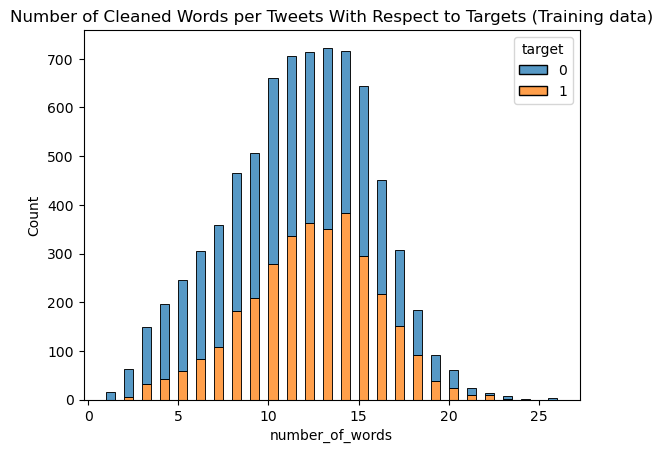

In [10]:
# How the number of words distributed
sns.histplot(
    df_train, 
    x = "number_of_words", 
    hue = "target", 
    multiple="stack").set(
        title = 'Number of Cleaned Words per Tweets With Respect to Targets (Training data)');

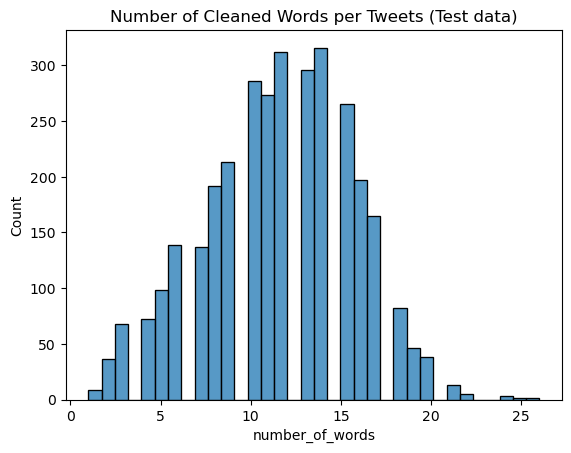

In [13]:
# How the number of words distributed
sns.histplot(
    df_test, 
    x = "number_of_words", 
    # hue = "target", 
    multiple="stack").set(
        title = 'Number of Cleaned Words per Tweets (Test data)');

### Building Vectors

* We'll use scikit-learn's `CountVectorizer` to count the words in each tweet and turn them into data our machine learning model can process. 

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing

In [28]:
count_vectorizer = CountVectorizer()

# Example vectors
example_train_vectors = count_vectorizer.fit_transform(df_train['cleaned_tweet'][0:5])

In [29]:
# We use .todense() here because these vectors are "sparse" (only non-zero elements are kept to save space)
print(example_train_vectors[0].todense().shape)
print(example_train_vectors[0].todense())

(1, 40)
[[0 0 0 0 1 0 0 0 1 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0
  0 0 0 0]]


In [30]:
# We use .todense() here because these vectors are "sparse" (only non-zero elements are kept to save space)
print(example_train_vectors[1].todense().shape)
print(example_train_vectors[1].todense())

(1, 40)
[[0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0
  0 0 0 0]]


In [31]:
train_vectors = count_vectorizer.fit_transform(df_train['cleaned_tweet'])
# Using just .transform() makes sure that the tokens in the train vectors are the only ones mapped to the test vectors - 
# i.e. that the train and test vectors use the same set of tokens.
test_vectors = count_vectorizer.transform(df_test['cleaned_tweet'])


In [33]:
## Our vectors are really big, so we want to push our model's weights
## toward 0 without completely discounting different words - ridge regression 
## is a good way to do this.
clf = linear_model.RidgeClassifier()

In [35]:
scores = model_selection.cross_val_score(clf, train_vectors, df_train["target"], cv=5, scoring="f1")
scores

array([0.57984791, 0.50666667, 0.58079625, 0.58596491, 0.68058778])

### TF-IDF

In [38]:
# Packages
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import ComplementNB
from sklearn.pipeline import Pipeline

# Define a pipeline combining a text feature vectorizer with a simple classifier yet effective for text classification.
pipeline = Pipeline(
    [
        ("vect", TfidfVectorizer()),
        ("clf", ComplementNB()),
    ]
)
pipeline

Pipeline(steps=[('vect', TfidfVectorizer()), ('clf', ComplementNB())])

In [36]:
parameter_grid = {
    "vect__max_df": (0.2, 0.4, 0.6, 0.8, 1.0),
    "vect__min_df": (1, 3, 5, 10),
    "vect__ngram_range": ((1, 1), (1, 2)),  # unigrams or bigrams
    "vect__norm": ("l1", "l2"),
    "clf__alpha": np.logspace(-6, 6, 13),
}

In this case `n_iter=40` is not an exhaustive search of the hyperparameters’ grid. __In practice it would be interesting to increase the parameter `n_iter` to get a more informative analysis__. As a consequence, the computional time increases. We can reduce it by taking advantage of the parallelisation over the parameter combinations evaluation by increasing the number of CPUs used via the parameter `n_jobs`.

In [39]:
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV

random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=parameter_grid,
    n_iter=80, # Documentation : 40
    random_state=0,
    n_jobs=-1,
    verbose=1,
)

print("Performing grid search...")
print("Hyperparameters to be evaluated:")
pprint(parameter_grid)

Performing grid search...
Hyperparameters to be evaluated:
{'clf__alpha': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01,
       1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06]),
 'vect__max_df': (0.2, 0.4, 0.6, 0.8, 1.0),
 'vect__min_df': (1, 3, 5, 10),
 'vect__ngram_range': ((1, 1), (1, 2)),
 'vect__norm': ('l1', 'l2')}


In [41]:
from time import time

# Apply random search on training data
t0 = time()
random_search.fit(df_train['cleaned_tweet'], df_train['target'])
print(f"Done in {time() - t0:.3f}s")

Fitting 5 folds for each of 80 candidates, totalling 400 fits


Done in 7.526s


In [42]:
# Best parameters for training data
print("Best parameters combination found:")
best_parameters = random_search.best_estimator_.get_params()
for param_name in sorted(parameter_grid.keys()):
    print(f"{param_name}: {best_parameters[param_name]}")

Best parameters combination found:
clf__alpha: 10.0
vect__max_df: 0.2
vect__min_df: 1
vect__ngram_range: (1, 1)
vect__norm: l2


In [43]:
# Accuracy of the best parameter for training data
test_accuracy = random_search.score(df_train['cleaned_tweet'], df_train['target'])
print(
    "Accuracy of the best parameters using the inner CV of "
    f"the random search: {random_search.best_score_:.3f}"
)
print(f"Accuracy on test set: {test_accuracy:.3f}")

Accuracy of the best parameters using the inner CV of the random search: 0.709
Accuracy on test set: 0.853


In [44]:
# The prefixes vect and clf are required to avoid possible ambiguities in the pipeline, but are not necessary for visualizing the results. 
# Because of this, we define a function that will rename the tuned hyperparameters and improve the readability.

def shorten_param(param_name):
    """Remove components' prefixes in param_name."""
    if "__" in param_name:
        return param_name.rsplit("__", 1)[1]
    return param_name


cv_results = pd.DataFrame(random_search.cv_results_)
cv_results = cv_results.rename(shorten_param, axis=1)

In [45]:
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,norm,ngram_range,min_df,max_df,alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.152078,0.005981,0.022066,0.004912,l2,"(1, 2)",3,1.0,10.0,"{'vect__norm': 'l2', 'vect__ngram_range': (1, ...",0.694682,0.666448,0.688116,0.691853,0.760841,0.700388,0.031820,11
1,0.132074,0.032037,0.022842,0.008184,l2,"(1, 2)",3,0.6,100.0,"{'vect__norm': 'l2', 'vect__ngram_range': (1, ...",0.686802,0.656599,0.694682,0.693824,0.764783,0.699338,0.035550,14
2,0.055380,0.006975,0.011737,0.001364,l1,"(1, 1)",10,0.6,0.01,"{'vect__norm': 'l1', 'vect__ngram_range': (1, ...",0.660538,0.603414,0.636901,0.645861,0.721419,0.653627,0.038743,79
3,0.111468,0.011263,0.018971,0.004496,l2,"(1, 2)",10,1.0,0.001,"{'vect__norm': 'l2', 'vect__ngram_range': (1, ...",0.669731,0.606697,0.648063,0.659001,0.737188,0.664136,0.042313,67
4,0.117206,0.016375,0.021687,0.005641,l2,"(1, 2)",3,0.2,1.0,"{'vect__norm': 'l2', 'vect__ngram_range': (1, ...",0.691399,0.656599,0.704531,0.705650,0.747700,0.701176,0.029252,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,0.099054,0.006658,0.018783,0.004012,l1,"(1, 2)",10,1.0,10.0,"{'vect__norm': 'l1', 'vect__ngram_range': (1, ...",0.692712,0.662508,0.688116,0.657687,0.754928,0.691190,0.034697,28
76,0.051543,0.002068,0.012317,0.002316,l1,"(1, 1)",10,0.4,0.00001,"{'vect__norm': 'l1', 'vect__ngram_range': (1, ...",0.669731,0.613920,0.642810,0.653745,0.718791,0.659799,0.034667,72
77,0.102410,0.009582,0.016492,0.000876,l1,"(1, 2)",3,0.2,0.1,"{'vect__norm': 'l1', 'vect__ngram_range': (1, ...",0.697965,0.634931,0.689429,0.711564,0.730618,0.692901,0.032153,26
78,0.100397,0.009980,0.016826,0.001316,l1,"(1, 2)",10,0.8,0.1,"{'vect__norm': 'l1', 'vect__ngram_range': (1, ...",0.669731,0.611950,0.652003,0.646518,0.729961,0.662032,0.038789,69


In [47]:
import plotly.express as px

param_names = [shorten_param(name) for name in parameter_grid.keys()]
labels = {
    "mean_score_time": "CV Score time (s)",
    "mean_test_score": "CV score (accuracy)",
}
fig = px.scatter(
    cv_results,
    x="mean_score_time",
    y="mean_test_score",
    error_x="std_score_time",
    error_y="std_test_score",
    hover_data=param_names,
    labels=labels,
)
fig.update_layout(
    title={
        "text": "trade-off between scoring time and mean test score",
        "y": 0.95,
        "x": 0.5,
        "xanchor": "center",
        "yanchor": "top",
    }
)
fig

In [48]:
from math import log10

column_results = param_names + ["mean_test_score", "mean_score_time"]

transform_funcs = dict.fromkeys(column_results, lambda x: x)
# Using a logarithmic scale for alpha
transform_funcs["alpha"] = log10
# L1 norms are mapped to index 1, and L2 norms to index 2
transform_funcs["norm"] = lambda x: 2 if x == "l2" else 1
# Unigrams are mapped to index 1 and bigrams to index 2
transform_funcs["ngram_range"] = lambda x: x[1]

fig = px.parallel_coordinates(
    cv_results[column_results].apply(transform_funcs),
    color="mean_test_score",
    color_continuous_scale=px.colors.sequential.Viridis_r,
    labels=labels,
)
fig.update_layout(
    title={
        "text": "Parallel coordinates plot of text classifier pipeline",
        "y": 0.99,
        "x": 0.5,
        "xanchor": "center",
        "yanchor": "top",
    }
)
fig

In [49]:
# Print the best parameters again
print("Best parameters combination found:")
best_parameters = random_search.best_estimator_.get_params()
for param_name in sorted(parameter_grid.keys()):
    print(f"{param_name}: {best_parameters[param_name]}")

Best parameters combination found:
clf__alpha: 10.0
vect__max_df: 0.2
vect__min_df: 1
vect__ngram_range: (1, 1)
vect__norm: l2


In [50]:
# Use the best parameters found by the pipeline
tfidf_vect = TfidfVectorizer(
    max_df = 0.2,
    min_df = 1,
    ngram_range = (1, 1),
    norm = 'l2',
    stop_words = 'english')

tfidf_vect_train = tfidf_vect.fit_transform(df_train['cleaned_tweet'].values)
tfidf_vect_test = tfidf_vect.transform(df_test['cleaned_tweet'].values)

print(f"TF-IDF vector of training data: {tfidf_vect_train.shape}")
print(f"TF-IDF vector of testing data: {tfidf_vect_test.shape}")
# tfidvec_test = tfidvec.fit_transform(df_test['cleaned_text'].values)
# print(f"TF-IDF vector of testing data: {tfidvec_test.shape}")

TF-IDF vector of training data: (7613, 19598)
TF-IDF vector of testing data: (3263, 19598)


In [51]:

clf = linear_model.RidgeClassifier()
scores = model_selection.cross_val_score(clf, tfidf_vect_train, df_train["target"], cv=5, scoring="f1")
scores

array([0.52878049, 0.51826678, 0.54591837, 0.53584906, 0.69015212])

## Modeling

### Keras BERT pretrained model

In [4]:
BATCH_SIZE = 32
NUM_TRAINING_EXAMPLES = df_train.shape[0]
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.2
STEPS_PER_EPOCH = int(NUM_TRAINING_EXAMPLES)*TRAIN_SPLIT // BATCH_SIZE

EPOCHS = 2
AUTO = tf.data.experimental.AUTOTUNE

In [5]:
# Training and validation dataset split
from sklearn.model_selection import train_test_split

X = df_train["text"]
y = df_train["target"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=VAL_SPLIT, random_state=42)

X_test = df_test["text"]

In [8]:
import keras_nlp
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

Using TensorFlow backend


In [ ]:
# Load a DistilBERT model.
preset= "distil_bert_base_en_uncased"

# Use a shorter sequence length.
preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(preset,
    sequence_length=160,
    name="preprocessor_4_tweets"
    )

# Pretrained classifier.
classifier = keras_nlp.models.DistilBertClassifier.from_preset(preset,
    preprocessor = preprocessor, 
    num_classes=2)

classifier.summary()

### TextVectorization

In [165]:
text_vectorization = TextVectorization(
    ngrams=2,
    max_tokens=15000,
    output_mode="tf_idf",
)

In [147]:
# Traing, validation, test dataset split
train_split=0.8
val_split=0.1
test_split=0.1
ds_size = df_train.shape[0]

# Create the dataset from slices of the texts and targets
dataset = tf.data.Dataset.from_tensor_slices((df_train['text'].values, df_train['target'].values))
# Shuffle the data with a buffer size equal to the length of the dataset
dataset = dataset.shuffle(ds_size)

# Train, validation, test set split
train_size = int(train_split * ds_size)
val_size = int(val_split * ds_size)

train_ds = dataset.take(train_size)
val_ds = dataset.skip(train_size).take(val_size)
test_ds = dataset.skip(train_size).skip(val_size)

In [148]:
# Prepare a dataset that only contains texts without targets
text_only_train_dataset = train_ds.map(lambda x, y: x)
# Use text_only_train_dataset to create index
text_vectorization.adapt(text_only_train_dataset)

# Parse the text data to the pixel values
ds_train_1gram = train_ds.map(lambda x, y: (text_vectorization(x), y), num_parallel_calls=4) # Use multiple threads to improve the speed of preprocessing
ds_val_1gram = val_ds.map(lambda x, y: (text_vectorization(x), y), num_parallel_calls=4) 
ds_test_1gram = test_ds.map(lambda x, y: (text_vectorization(x), y), num_parallel_calls=4) 

# Traing batch and steps
num_train_samples = tf.data.experimental.cardinality(ds_train_1gram).numpy()
num_val_samples = tf.data.experimental.cardinality(ds_val_1gram).numpy()
num_test_samples = tf.data.experimental.cardinality(ds_test_1gram).numpy()
batch_size = 32
train_steps = np.ceil(num_train_samples / batch_size)
val_steps = np.ceil(num_val_samples / batch_size)

ds_train_1gram = ds_train_1gram.batch(batch_size)
ds_train_1gram = ds_train_1gram.prefetch(1)
ds_val_1gram = ds_val_1gram.batch(batch_size)
ds_val_1gram = ds_val_1gram.prefetch(1)
ds_test_1gram = ds_test_1gram.batch(batch_size)
ds_test_1gram = ds_test_1gram.prefetch(1)

print(f"Amount of subset dataset: {ds_size}")
print(f"Number of training images: {num_train_samples}")
print(f"Number of validation images: {num_val_samples}")
print(f"Number of test images: {num_test_samples}")

Amount of subset dataset: 7613
Number of training images: 6090
Number of validation images: 761
Number of test images: 762


In [149]:
for inputs, targets in ds_train_1gram:
    print("Input shape", inputs.shape)
    print("Input dtype", inputs.dtype)
    print("Target dtype", targets.dtype)
    print("Target dtype", targets.dtype)
    print("Input", inputs[0])
    print("Target", targets[0])
    break

Input shape (32, 600)
Input dtype <dtype: 'float32'>
Target dtype <dtype: 'int64'>
Target dtype <dtype: 'int64'>
Input tf.Tensor(
[1. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

In [159]:
# 2 gram
# Use text_only_train_dataset to create index
text_vectorization.adapt(text_only_train_dataset)

# Parse the text data to the pixel values
ds_train_2gram = train_ds.map(lambda x, y: (text_vectorization(x), y), num_parallel_calls=4) # Use multiple threads to improve the speed of preprocessing
ds_val_2gram = val_ds.map(lambda x, y: (text_vectorization(x), y), num_parallel_calls=4) 
ds_test_2gram = test_ds.map(lambda x, y: (text_vectorization(x), y), num_parallel_calls=4) 

# Traing batch and steps
num_train_samples = tf.data.experimental.cardinality(ds_train_2gram).numpy()
num_val_samples = tf.data.experimental.cardinality(ds_val_2gram).numpy()
num_test_samples = tf.data.experimental.cardinality(ds_test_2gram).numpy()
batch_size = 32
train_steps = np.ceil(num_train_samples / batch_size)
val_steps = np.ceil(num_val_samples / batch_size)

ds_train_2gram = ds_train_2gram.batch(batch_size)
ds_train_2gram = ds_train_2gram.prefetch(1)
ds_val_2gram = ds_val_2gram.batch(batch_size)
ds_val_2gram = ds_val_2gram.prefetch(1)
ds_test_2gram = ds_test_2gram.batch(batch_size)
ds_test_2gram = ds_test_2gram.prefetch(1)

print(f"Amount of subset dataset: {ds_size}")
print(f"Number of training images: {num_train_samples}")
print(f"Number of validation images: {num_val_samples}")
print(f"Number of test images: {num_test_samples}")

Amount of subset dataset: 7613
Number of training images: 6090
Number of validation images: 761
Number of test images: 762


In [166]:
# TF-IDF
# Use text_only_train_dataset to create index
text_vectorization.adapt(text_only_train_dataset)

# Parse the text data to the pixel values
ds_train_tfidf = train_ds.map(lambda x, y: (text_vectorization(x), y), num_parallel_calls=4) # Use multiple threads to improve the speed of preprocessing
ds_val_tfidf = val_ds.map(lambda x, y: (text_vectorization(x), y), num_parallel_calls=4) 
ds_test_tfidf = test_ds.map(lambda x, y: (text_vectorization(x), y), num_parallel_calls=4) 

# Traing batch and steps
num_train_samples = tf.data.experimental.cardinality(ds_train_tfidf).numpy()
num_val_samples = tf.data.experimental.cardinality(ds_val_tfidf).numpy()
num_test_samples = tf.data.experimental.cardinality(ds_test_tfidf).numpy()
batch_size = 32
train_steps = np.ceil(num_train_samples / batch_size)
val_steps = np.ceil(num_val_samples / batch_size)

ds_train_tfidf = ds_train_tfidf.batch(batch_size)
ds_train_tfidf = ds_train_tfidf.prefetch(1)
ds_val_tfidf = ds_val_tfidf.batch(batch_size)
ds_val_tfidf = ds_val_tfidf.prefetch(1)
ds_test_tfidf = ds_test_tfidf.batch(batch_size)
ds_test_tfidf = ds_test_tfidf.prefetch(1)

print(f"Amount of subset dataset: {ds_size}")
print(f"Number of training images: {num_train_samples}")
print(f"Number of validation images: {num_val_samples}")
print(f"Number of test images: {num_test_samples}")

Amount of subset dataset: 7613
Number of training images: 6090
Number of validation images: 761
Number of test images: 762


In [71]:
# TF-IDF
# Prepare a dataset that only contains texts
text_only_train_dataset = train_ds.map(lambda x, y: x)
# Use text_only_train_dataset to create index
text_vectorization.adapt(text_only_train_dataset)

# Parse the text data to the pixel values
ds_train_tfidf_2gram = train_ds.map(parse_function, num_parallel_calls=4) # Use multiple threads to improve the speed of preprocessing
ds_val_tfidf_2gram = val_ds.map(parse_function, num_parallel_calls=4) 
ds_test_tfidf_2gram = test_ds.map(parse_function, num_parallel_calls=4) 

# Traing batch and steps
num_train_samples = tf.data.experimental.cardinality(ds_train_tfidf_2gram).numpy()
num_val_samples = tf.data.experimental.cardinality(ds_val_tfidf_2gram).numpy()
num_test_samples = tf.data.experimental.cardinality(ds_test_tfidf_2gram).numpy()
batch_size = 32
train_steps = np.ceil(num_train_samples / batch_size)
val_steps = np.ceil(num_val_samples / batch_size)

ds_train_tfidf_2gram = ds_train_tfidf_2gram.batch(batch_size)
ds_train_tfidf_2gram = ds_train_tfidf_2gram.prefetch(1)
ds_val_tfidf_2gram = ds_val_tfidf_2gram.batch(batch_size)
ds_val_tfidf_2gram = ds_val_tfidf_2gram.prefetch(1)
ds_test_tfidf_2gram = ds_test_tfidf_2gram.batch(batch_size)
ds_test_tfidf_2gram = ds_test_tfidf_2gram.prefetch(1)

print(f"Amount of subset dataset: {ds_size}")
print(f"Number of training images: {num_train_samples}")
print(f"Number of validation images: {num_val_samples}")
print(f"Number of test images: {num_test_samples}")

Amount of subset dataset: 7613
Number of training images: 6090
Number of validation images: 761
Number of test images: 762


In [49]:
for f, v in ds_train_2gram:
    print(f.shape)
    print(v.shape)
    # print(f)
    break

(32, 10000)
(32,)


In [28]:
v

<tf.Tensor: shape=(32, 1), dtype=int64, numpy=
array([[1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]], dtype=int64)>

In [202]:
from keras import backend as K

# Custom F1 score metrics, from https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

# F1 score
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# Define a simple model
def get_model(max_token=600, hidden_dim=16, name='model_'):
    inputs = keras.Input(shape=max_token)
    x = keras.layers.Dense(hidden_dim, activation='relu')(inputs)
    x = keras.layers.Dropout(.5)(x)
    outputs = keras.layers.Dense(1, activation='sigmoid')(x)
    model = keras.Model(inputs, outputs, name=name)
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy', # keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy',f1_m, precision_m, recall_m]
    )
    return model

def plot_confusion_matrix(y_true, y_pred, dataset):
    y_pred = tf.squeeze(y_pred)
    y_pred = np.array([1 if x >= 0.5 else 0 for x in y_pred])
    plot = ConfusionMatrixDisplay.from_predictions(
        y_true,
        y_pred,
        # np.argmax(y_pred, axis=1),
        display_labels=["Not Disaster", "Disaster"],
        cmap=plt.cm.Blues
    )

    # tn, fp, fn, tp = confusion_matrix(y_true, np.argmax(y_pred, axis=1)).ravel()
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    f1_score = tp / (tp+((fn+fp)/2))

    plot.ax_.set_title("Confusion Matrix on " + dataset + " Dataset -- F1 Score: " + str(f1_score.round(2)))


#### First model

In [150]:
model_name = 'model_1'
model = get_model(name=model_name)
print(model.summary())

callbacks = [
    keras.callbacks.ModelCheckpoint("binary_1gram.keras_", save_best_only=True)
]

history=model.fit(
    ds_train_1gram.cache(),
    validation_data=ds_val_1gram.cache(),
    epochs=10,
    callbacks=callbacks,
)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 600)]             0         
                                                                 
 dense_30 (Dense)            (None, 16)                9616      
                                                                 
 dropout_15 (Dropout)        (None, 16)                0         
                                                                 
 dense_31 (Dense)            (None, 1)                 17        
                                                                 
Total params: 9,633
Trainable params: 9,633
Non-trainable params: 0
_________________________________________________________________


None
Epoch 1/10
191/191 [==============================] - 2s 7ms/step - loss: 0.6531 - accuracy: 0.6271 - val_loss: 0.5980 - val_accuracy: 0.7411
Epoch 2/10
191/191 [==============================] - 1s 7ms/step - loss: 0.5828 - accuracy: 0.7261 - val_loss: 0.5260 - val_accuracy: 0.7806
Epoch 3/10
191/191 [==============================] - 1s 7ms/step - loss: 0.5339 - accuracy: 0.7532 - val_loss: 0.4816 - val_accuracy: 0.7989
Epoch 4/10
191/191 [==============================] - 1s 8ms/step - loss: 0.5065 - accuracy: 0.7685 - val_loss: 0.4539 - val_accuracy: 0.8081
Epoch 5/10
191/191 [==============================] - 1s 7ms/step - loss: 0.4809 - accuracy: 0.7836 - val_loss: 0.4330 - val_accuracy: 0.8147
Epoch 6/10
191/191 [==============================] - 1s 8ms/step - loss: 0.4706 - accuracy: 0.7936 - val_loss: 0.4193 - val_accuracy: 0.8160
Epoch 7/10
191/191 [==============================] - 1s 8ms/step - loss: 0.4573 - accuracy: 0.8011 - val_loss: 0.4078 - val_accuracy: 0.8160
E

In [151]:
test_model = keras.models.load_model('binary_1gram.keras_')

test_loss, test_acc = test_model.evaluate(ds_test_1gram.cache())
print(f"Test accuracy: {test_acc:.3f}")

24/24 [==============================] - 0s 5ms/step - loss: 0.3882 - accuracy: 0.8360
Test accuracy: 0.836


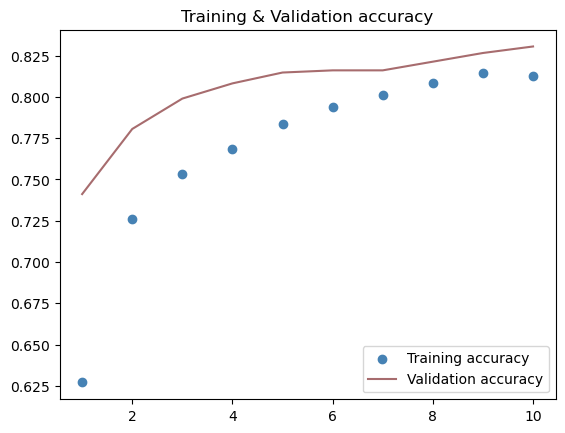

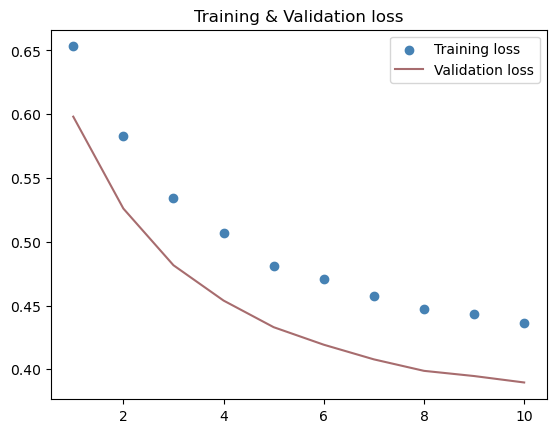

<Figure size 640x480 with 0 Axes>

In [152]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy)+1)
plt.scatter(epochs, accuracy, c=mycolors['blue'], marker='o', label = 'Training accuracy')
plt.plot(epochs, val_accuracy, c=mycolors['red'], label = 'Validation accuracy')
plt.title('Training & Validation accuracy')
plt.legend()
plt.figure();
plt.scatter(epochs, loss, c=mycolors['blue'], marker='o', label = 'Training loss')
plt.plot(epochs, val_loss, c=mycolors['red'], label = 'Validation loss')
plt.title('Training & Validation loss')
plt.legend()
plt.figure();

24/24 [==============================] - 0s 3ms/step


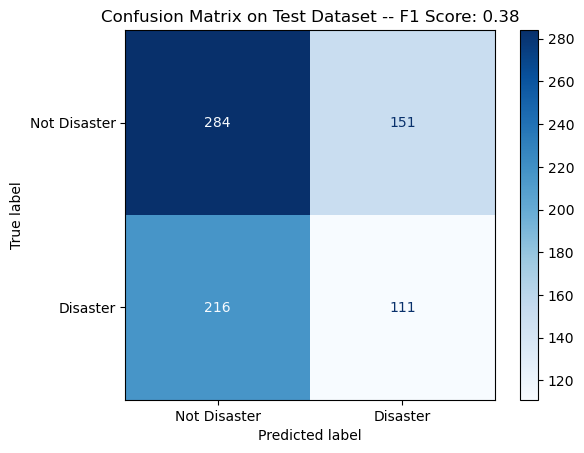

In [157]:
# True target
true = [target.numpy() for _, target in test_ds]
pred = test_model.predict(ds_test_1gram.cache())
plot_confusion_matrix(true, pred, 'Test')

#### Second model

In [161]:
# Apply two gram
model_name = 'model_2'
model = get_model(max_token=10000, name=model_name,)
print(model.summary())

callbacks = [
    keras.callbacks.ModelCheckpoint("binary_2gram.keras_", save_best_only=True)
]

history=model.fit(
    ds_train_2gram.cache(),
    validation_data=ds_val_2gram.cache(),
    epochs=10,
    callbacks=callbacks,
)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 10000)]           0         
                                                                 
 dense_34 (Dense)            (None, 16)                160016    
                                                                 
 dropout_17 (Dropout)        (None, 16)                0         
                                                                 
 dense_35 (Dense)            (None, 1)                 17        
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


None
Epoch 1/10
191/191 [==============================] - 2s 8ms/step - loss: 0.6159 - accuracy: 0.6964 - val_loss: 0.5064 - val_accuracy: 0.8331
Epoch 2/10
191/191 [==============================] - 1s 7ms/step - loss: 0.4963 - accuracy: 0.7913 - val_loss: 0.4147 - val_accuracy: 0.8528
Epoch 3/10
191/191 [==============================] - 2s 8ms/step - loss: 0.4334 - accuracy: 0.8289 - val_loss: 0.3678 - val_accuracy: 0.8686
Epoch 4/10
191/191 [==============================] - 1s 8ms/step - loss: 0.4039 - accuracy: 0.8414 - val_loss: 0.3395 - val_accuracy: 0.8778
Epoch 5/10
191/191 [==============================] - 1s 7ms/step - loss: 0.3737 - accuracy: 0.8548 - val_loss: 0.3206 - val_accuracy: 0.8765
Epoch 6/10
191/191 [==============================] - 1s 8ms/step - loss: 0.3580 - accuracy: 0.8609 - val_loss: 0.3080 - val_accuracy: 0.8844
Epoch 7/10
191/191 [==============================] - 1s 7ms/step - loss: 0.3399 - accuracy: 0.8675 - val_loss: 0.2986 - val_accuracy: 0.8857
E

In [162]:
test_model = keras.models.load_model('binary_2gram.keras_')

test_loss, test_acc = test_model.evaluate(ds_test_2gram.cache())
print(f"Test accuracy: {test_acc:.3f}")

24/24 [==============================] - 0s 5ms/step - loss: 0.3607 - accuracy: 0.8530
Test accuracy: 0.853


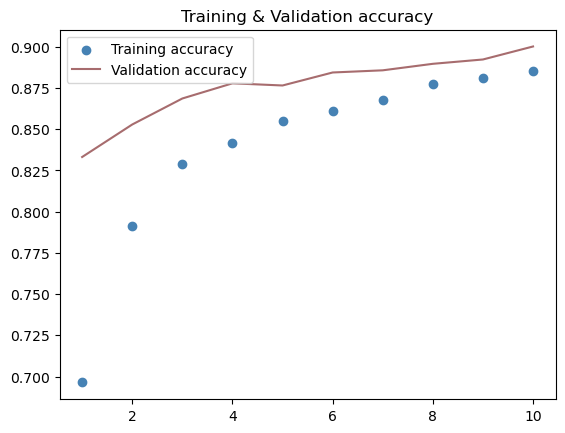

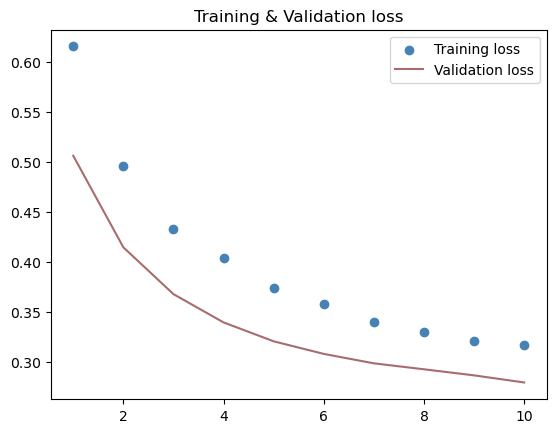

<Figure size 640x480 with 0 Axes>

In [163]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy)+1)
plt.scatter(epochs, accuracy, c=mycolors['blue'], marker='o', label = 'Training accuracy')
plt.plot(epochs, val_accuracy, c=mycolors['red'], label = 'Validation accuracy')
plt.title('Training & Validation accuracy')
plt.legend()
plt.figure();
plt.scatter(epochs, loss, c=mycolors['blue'], marker='o', label = 'Training loss')
plt.plot(epochs, val_loss, c=mycolors['red'], label = 'Validation loss')
plt.title('Training & Validation loss')
plt.legend()
plt.figure();

24/24 [==============================] - 0s 4ms/step


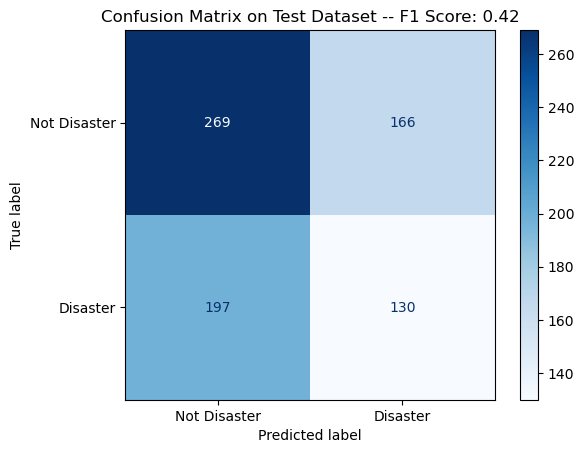

In [164]:
# True target
pred = test_model.predict(ds_test_2gram.cache())
plot_confusion_matrix(true, pred, 'Test')

#### Third model

In [183]:
# Apply TF-IDF
model_name = 'model_3'
model = get_model(max_token=15000, name=model_name)
print(model.summary())

callbacks = [
    keras.callbacks.ModelCheckpoint("binary_TFIDF.keras_", save_best_only=True)
]

history=model.fit(
    ds_train_tfidf.cache(),
    validation_data=ds_val_tfidf.cache(),
    epochs=10,
    callbacks=callbacks,
)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 15000)]           0         
                                                                 
 dense_42 (Dense)            (None, 16)                240016    
                                                                 
 dropout_21 (Dropout)        (None, 16)                0         
                                                                 
 dense_43 (Dense)            (None, 1)                 17        
                                                                 
Total params: 240,033
Trainable params: 240,033
Non-trainable params: 0
_________________________________________________________________


None
Epoch 1/10
191/191 [==============================] - 2s 10ms/step - loss: 0.5939 - accuracy: 0.6890 - f1_m: 0.5878 - precision_m: 0.6793 - recall_m: 0.5463 - val_loss: 0.4390 - val_accuracy: 0.8305 - val_f1_m: 0.7792 - val_precision_m: 0.8510 - val_recall_m: 0.7279
Epoch 2/10
191/191 [==============================] - 1s 6ms/step - loss: 0.4196 - accuracy: 0.8230 - f1_m: 0.7754 - precision_m: 0.8369 - recall_m: 0.7362 - val_loss: 0.3214 - val_accuracy: 0.8765 - val_f1_m: 0.8465 - val_precision_m: 0.8949 - val_recall_m: 0.8094
Epoch 3/10
191/191 [==============================] - 1s 7ms/step - loss: 0.3168 - accuracy: 0.8765 - f1_m: 0.8438 - precision_m: 0.9024 - recall_m: 0.8026 - val_loss: 0.2579 - val_accuracy: 0.9001 - val_f1_m: 0.8790 - val_precision_m: 0.9194 - val_recall_m: 0.8480
Epoch 4/10
191/191 [==============================] - 1s 6ms/step - loss: 0.2458 - accuracy: 0.9030 - f1_m: 0.8798 - precision_m: 0.9285 - recall_m: 0.8441 - val_loss: 0.2304 - val_accuracy: 0.910

In [193]:
test_model = keras.models.load_model('binary_TFIDF.keras_', compile=False) #custom_objects={'f1_m':f1_m, 'precison_m' : precision_m, 'recall_m' : recall_m})
test_model.compile(
        optimizer='adam',
        loss='binary_crossentropy', # keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy',f1_m, precision_m, recall_m]
)

test_loss, test_acc, test_f1, test_precision, test_recall = test_model.evaluate(ds_test_tfidf.cache())
print(f"Test accuracy: {test_acc:.3f}")
print(f"Test F1 score: {test_f1:.3f}")

Test accuracy: 0.936
Test F1 score: 0.913


In [195]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'f1_m', 'precision_m', 'recall_m', 'val_loss', 'val_accuracy', 'val_f1_m', 'val_precision_m', 'val_recall_m'])

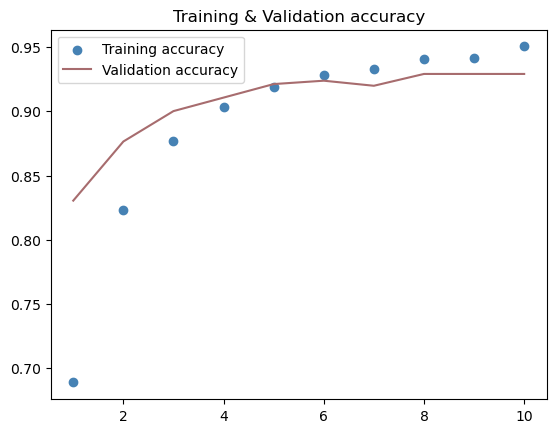

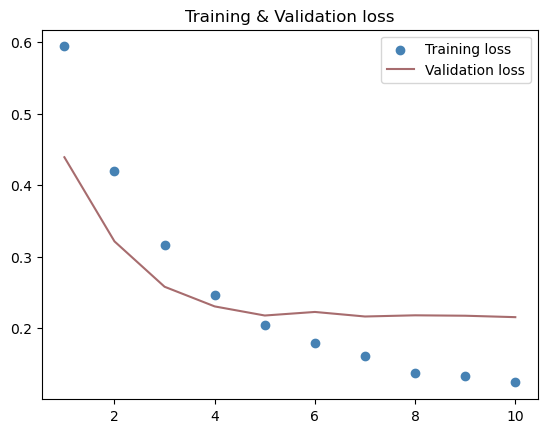

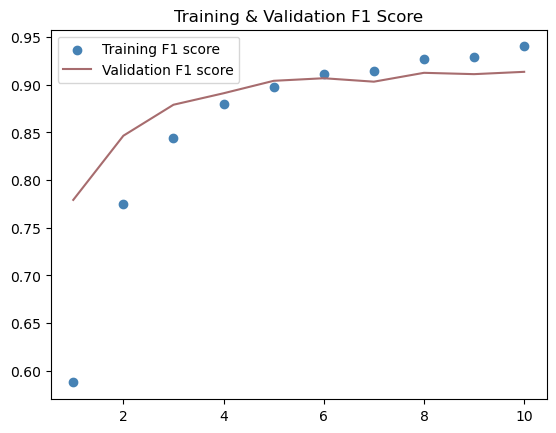

<Figure size 640x480 with 0 Axes>

In [196]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
f1_score = history.history['f1_m']
val_f1_score = history.history['val_f1_m']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy)+1)
plt.scatter(epochs, accuracy, c=mycolors['blue'], marker='o', label = 'Training accuracy')
plt.plot(epochs, val_accuracy, c=mycolors['red'], label = 'Validation accuracy')
plt.title('Training & Validation accuracy')
plt.legend()
plt.figure();
plt.scatter(epochs, loss, c=mycolors['blue'], marker='o', label = 'Training loss')
plt.plot(epochs, val_loss, c=mycolors['red'], label = 'Validation loss')
plt.title('Training & Validation loss')
plt.legend()
plt.figure();
plt.scatter(epochs, f1_score, c=mycolors['blue'], marker='o', label = 'Training F1 score')
plt.plot(epochs, val_f1_score, c=mycolors['red'], label = 'Validation F1 score')
plt.title('Training & Validation F1 Score')
plt.legend()
plt.figure();

#### Fourth model

### Sequence model

#### Prepare dataset

In [212]:
max_length=500
max_tokens=15000
text_vectorization = keras.layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode='int',
    output_sequence_length=max_length,
)
text_vectorization.adapt(text_only_train_dataset)

int_train_dataset = train_ds.map(lambda x, y: (text_vectorization(x), y), num_parallel_calls=4)
int_val_dataset = val_ds.map(lambda x, y: (text_vectorization(x), y), num_parallel_calls=4)
int_test_dataset = test_ds.map(lambda x, y: (text_vectorization(x), y), num_parallel_calls=4)

int_train_dataset = int_train_dataset.batch(32)
int_train_dataset = int_train_dataset.prefetch(1)
int_val_dataset = int_val_dataset.batch(32)
int_val_dataset = int_val_dataset.prefetch(1)
int_test_dataset = int_test_dataset.batch(32)
int_test_dataset = int_test_dataset.prefetch(1)

#### Bidirectional LSTM

In [204]:
# None means the input length is not fixed
inputs=keras.Input(shape=(None,), dtype='int64')
# Encode each int to one-hot vectors with 20000 dimension, shape (batch, 600, 20000)
embedded=tf.one_hot(inputs, depth=max_tokens)
x=layers.Bidirectional(layers.LSTM(32))(embedded)
x=layers.Dropout(.5)(x)
outputs=layers.Dense(1, activation='sigmoid')(x)
model=keras.Model(inputs, outputs)
model.compile(
    optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=['accuracy',f1_m, precision_m, recall_m]
)

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint('one_hot_bidir_lstm.keras_', save_best_only=True)
]
model.fit(
    int_train_dataset,
    epochs=10,
    validation_data=int_val_dataset,
    callbacks=callbacks
)

#### Word embedding model

In [214]:
inputs=keras.Input(shape=(None,), dtype='int64')
embedded=keras.layers.Embedding(input_dim=max_tokens, output_dim=256)(inputs)
x=keras.layers.Bidirectional(keras.layers.LSTM(32, ))(embedded)
x=keras.layers.Dropout(.5)(x)
outputs=keras.layers.Dense(1, activation='sigmoid')(x)
model=keras.Model(inputs, outputs)
model.compile(
    optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=['accuracy',f1_m, precision_m, recall_m]
)
print(model.summary())

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_28 (InputLayer)       [(None, None)]            0         
                                                                 
 embedding_4 (Embedding)     (None, None, 256)         3840000   
                                                                 
 bidirectional_5 (Bidirectio  (None, 64)               73984     
 nal)                                                            
                                                                 
 dropout_27 (Dropout)        (None, 64)                0         
                                                                 
 dense_49 (Dense)            (None, 1)                 65        
                                                                 
Total params: 3,914,049
Trainable params: 3,914,049
Non-trainable params: 0
_________________________________________________

In [209]:
for input_, targets in int_train_dataset:
    print(input_.shape)
    break

(500,)


In [215]:
callbacks = [
    keras.callbacks.ModelCheckpoint('embedding_bidir_lstm.keras_', save_best_only=True)
]
history=model.fit(
    int_train_dataset,
    epochs=10,
    validation_data=int_val_dataset,
    callbacks=callbacks
)

Epoch 1/10
191/191 [==============================] - ETA: 0s - loss: 0.5501 - accuracy: 0.7274 - f1_m: 0.5529 - precision_m: 0.7218 - recall_m: 0.4982

INFO:tensorflow:Assets written to: embedding_bidir_lstm.keras_\assets


INFO:tensorflow:Assets written to: embedding_bidir_lstm.keras_\assets


191/191 [==============================] - 21s 92ms/step - loss: 0.5501 - accuracy: 0.7274 - f1_m: 0.5529 - precision_m: 0.7218 - recall_m: 0.4982 - val_loss: 0.3947 - val_accuracy: 0.8305 - val_f1_m: 0.7686 - val_precision_m: 0.8702 - val_recall_m: 0.7048
Epoch 2/10
191/191 [==============================] - ETA: 0s - loss: 0.3845 - accuracy: 0.8435 - f1_m: 0.7961 - precision_m: 0.8672 - recall_m: 0.7488

INFO:tensorflow:Assets written to: embedding_bidir_lstm.keras_\assets


INFO:tensorflow:Assets written to: embedding_bidir_lstm.keras_\assets


191/191 [==============================] - 18s 93ms/step - loss: 0.3845 - accuracy: 0.8435 - f1_m: 0.7961 - precision_m: 0.8672 - recall_m: 0.7488 - val_loss: 0.3245 - val_accuracy: 0.8673 - val_f1_m: 0.8266 - val_precision_m: 0.9541 - val_recall_m: 0.7407
Epoch 3/10
191/191 [==============================] - ETA: 0s - loss: 0.3321 - accuracy: 0.8660 - f1_m: 0.8310 - precision_m: 0.8888 - recall_m: 0.7916

INFO:tensorflow:Assets written to: embedding_bidir_lstm.keras_\assets


INFO:tensorflow:Assets written to: embedding_bidir_lstm.keras_\assets


191/191 [==============================] - 17s 90ms/step - loss: 0.3321 - accuracy: 0.8660 - f1_m: 0.8310 - precision_m: 0.8888 - recall_m: 0.7916 - val_loss: 0.2679 - val_accuracy: 0.8975 - val_f1_m: 0.8756 - val_precision_m: 0.9063 - val_recall_m: 0.8527
Epoch 4/10
191/191 [==============================] - 11s 57ms/step - loss: 0.2949 - accuracy: 0.8856 - f1_m: 0.8558 - precision_m: 0.8981 - recall_m: 0.8255 - val_loss: 0.2856 - val_accuracy: 0.8791 - val_f1_m: 0.8441 - val_precision_m: 0.9467 - val_recall_m: 0.7696
Epoch 5/10
191/191 [==============================] - ETA: 0s - loss: 0.2636 - accuracy: 0.9025 - f1_m: 0.8797 - precision_m: 0.9260 - recall_m: 0.8469

INFO:tensorflow:Assets written to: embedding_bidir_lstm.keras_\assets


INFO:tensorflow:Assets written to: embedding_bidir_lstm.keras_\assets


191/191 [==============================] - 17s 88ms/step - loss: 0.2636 - accuracy: 0.9025 - f1_m: 0.8797 - precision_m: 0.9260 - recall_m: 0.8469 - val_loss: 0.2563 - val_accuracy: 0.9093 - val_f1_m: 0.8758 - val_precision_m: 0.9493 - val_recall_m: 0.8217
Epoch 6/10
191/191 [==============================] - ETA: 0s - loss: 0.2263 - accuracy: 0.9187 - f1_m: 0.8985 - precision_m: 0.9318 - recall_m: 0.8747

INFO:tensorflow:Assets written to: embedding_bidir_lstm.keras_\assets


INFO:tensorflow:Assets written to: embedding_bidir_lstm.keras_\assets


191/191 [==============================] - 17s 88ms/step - loss: 0.2263 - accuracy: 0.9187 - f1_m: 0.8985 - precision_m: 0.9318 - recall_m: 0.8747 - val_loss: 0.1713 - val_accuracy: 0.9422 - val_f1_m: 0.9276 - val_precision_m: 0.9595 - val_recall_m: 0.9014
Epoch 7/10
191/191 [==============================] - 11s 56ms/step - loss: 0.2151 - accuracy: 0.9232 - f1_m: 0.9054 - precision_m: 0.9365 - recall_m: 0.8829 - val_loss: 0.1885 - val_accuracy: 0.9251 - val_f1_m: 0.9011 - val_precision_m: 0.9790 - val_recall_m: 0.8437
Epoch 8/10
191/191 [==============================] - ETA: 0s - loss: 0.1840 - accuracy: 0.9363 - f1_m: 0.9197 - precision_m: 0.9516 - recall_m: 0.8957

INFO:tensorflow:Assets written to: embedding_bidir_lstm.keras_\assets


INFO:tensorflow:Assets written to: embedding_bidir_lstm.keras_\assets


191/191 [==============================] - 17s 89ms/step - loss: 0.1840 - accuracy: 0.9363 - f1_m: 0.9197 - precision_m: 0.9516 - recall_m: 0.8957 - val_loss: 0.1480 - val_accuracy: 0.9435 - val_f1_m: 0.9292 - val_precision_m: 0.9888 - val_recall_m: 0.8810
Epoch 9/10
190/191 [============================>.] - ETA: 0s - loss: 0.1675 - accuracy: 0.9429 - f1_m: 0.9296 - precision_m: 0.9540 - recall_m: 0.9109

INFO:tensorflow:Assets written to: embedding_bidir_lstm.keras_\assets


INFO:tensorflow:Assets written to: embedding_bidir_lstm.keras_\assets


191/191 [==============================] - 18s 95ms/step - loss: 0.1674 - accuracy: 0.9430 - f1_m: 0.9300 - precision_m: 0.9543 - recall_m: 0.9114 - val_loss: 0.1421 - val_accuracy: 0.9540 - val_f1_m: 0.9433 - val_precision_m: 0.9709 - val_recall_m: 0.9211
Epoch 10/10
190/191 [============================>.] - ETA: 0s - loss: 0.1504 - accuracy: 0.9474 - f1_m: 0.9350 - precision_m: 0.9572 - recall_m: 0.9191

INFO:tensorflow:Assets written to: embedding_bidir_lstm.keras_\assets


INFO:tensorflow:Assets written to: embedding_bidir_lstm.keras_\assets


191/191 [==============================] - 17s 90ms/step - loss: 0.1503 - accuracy: 0.9475 - f1_m: 0.9354 - precision_m: 0.9574 - recall_m: 0.9195 - val_loss: 0.1091 - val_accuracy: 0.9632 - val_f1_m: 0.9511 - val_precision_m: 0.9684 - val_recall_m: 0.9382


In [217]:
test_model = keras.models.load_model('embedding_bidir_lstm.keras_', compile=False) #custom_objects={'f1_m':f1_m, 'precison_m' : precision_m, 'recall_m' : recall_m})
test_model.compile(
        optimizer='rmsprop',
        loss='binary_crossentropy', # keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy',f1_m, precision_m, recall_m]
)

test_loss, test_acc, test_f1, test_precision, test_recall = test_model.evaluate(int_test_dataset)
print(f"Test accuracy: {test_acc:.3f}")
print(f"Test F1 score: {test_f1:.3f}")

24/24 [==============================] - 2s 28ms/step - loss: 0.0944 - accuracy: 0.9724 - f1_m: 0.9609 - precision_m: 0.9723 - recall_m: 0.9519
Test accuracy: 0.972
Test F1 score: 0.961


In [221]:
test_recall

0.9518961310386658

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
f1_score = history.history['f1_m']
val_f1_score = history.history['val_f1_m']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy)+1)
plt.scatter(epochs, accuracy, c=mycolors['blue'], marker='o', label = 'Training accuracy')
plt.plot(epochs, val_accuracy, c=mycolors['red'], label = 'Validation accuracy')
plt.title('Training & Validation accuracy')
plt.legend()
plt.figure();
plt.scatter(epochs, loss, c=mycolors['blue'], marker='o', label = 'Training loss')
plt.plot(epochs, val_loss, c=mycolors['red'], label = 'Validation loss')
plt.title('Training & Validation loss')
plt.legend()
plt.figure();
plt.scatter(epochs, f1_score, c=mycolors['blue'], marker='o', label = 'Training F1 score')
plt.plot(epochs, val_f1_score, c=mycolors['red'], label = 'Validation F1 score')
plt.title('Training & Validation F1 Score')
plt.legend()
plt.figure();

#### Word embedding model with masking

In [222]:
inputs=keras.Input(shape=(None,), dtype='int64')
embedded=keras.layers.Embedding(input_dim=max_tokens, output_dim=256, mask_zero=True)(inputs)
x=keras.layers.Bidirectional(keras.layers.LSTM(32,))(embedded)
x=keras.layers.Dropout(.5)(x)
outputs=keras.layers.Dense(1, activation='sigmoid')(x)
model=keras.Model(inputs, outputs)
model.compile(
    optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=['accuracy',f1_m, precision_m, recall_m]
)
print(model.summary())

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_29 (InputLayer)       [(None, None)]            0         
                                                                 
 embedding_5 (Embedding)     (None, None, 256)         3840000   
                                                                 
 bidirectional_6 (Bidirectio  (None, 64)               73984     
 nal)                                                            
                                                                 
 dropout_28 (Dropout)        (None, 64)                0         
                                                                 
 dense_50 (Dense)            (None, 1)                 65        
                                                                 
Total params: 3,914,049
Trainable params: 3,914,049
Non-trainable params: 0
_________________________________________________

In [223]:
callbacks = [
    keras.callbacks.ModelCheckpoint('embedding_bidir_lstm_with_masking.keras_', save_best_only=True)
]
history=model.fit(
    int_train_dataset,
    epochs=10,
    validation_data=int_val_dataset,
    callbacks=callbacks
)

Epoch 1/10
188/191 [============================>.] - ETA: 0s - loss: 0.5194 - accuracy: 0.7613 - f1_m: 0.6396 - precision_m: 0.7891 - recall_m: 0.5838

INFO:tensorflow:Assets written to: embedding_bidir_lstm_with_masking.keras_\assets


INFO:tensorflow:Assets written to: embedding_bidir_lstm_with_masking.keras_\assets


191/191 [==============================] - 28s 112ms/step - loss: 0.5176 - accuracy: 0.7622 - f1_m: 0.6415 - precision_m: 0.7898 - recall_m: 0.5865 - val_loss: 0.3647 - val_accuracy: 0.8555 - val_f1_m: 0.8042 - val_precision_m: 0.9179 - val_recall_m: 0.7255
Epoch 2/10
188/191 [============================>.] - ETA: 0s - loss: 0.3676 - accuracy: 0.8456 - f1_m: 0.8003 - precision_m: 0.8730 - recall_m: 0.7493

INFO:tensorflow:Assets written to: embedding_bidir_lstm_with_masking.keras_\assets


INFO:tensorflow:Assets written to: embedding_bidir_lstm_with_masking.keras_\assets


191/191 [==============================] - 20s 103ms/step - loss: 0.3687 - accuracy: 0.8448 - f1_m: 0.8001 - precision_m: 0.8733 - recall_m: 0.7487 - val_loss: 0.3116 - val_accuracy: 0.8633 - val_f1_m: 0.8219 - val_precision_m: 0.8852 - val_recall_m: 0.7773
Epoch 3/10
189/191 [============================>.] - ETA: 0s - loss: 0.3246 - accuracy: 0.8725 - f1_m: 0.8396 - precision_m: 0.8916 - recall_m: 0.8010

INFO:tensorflow:Assets written to: embedding_bidir_lstm_with_masking.keras_\assets


INFO:tensorflow:Assets written to: embedding_bidir_lstm_with_masking.keras_\assets


191/191 [==============================] - 20s 103ms/step - loss: 0.3239 - accuracy: 0.8729 - f1_m: 0.8406 - precision_m: 0.8928 - recall_m: 0.8019 - val_loss: 0.2465 - val_accuracy: 0.9054 - val_f1_m: 0.8843 - val_precision_m: 0.9271 - val_recall_m: 0.8519
Epoch 4/10
190/191 [============================>.] - ETA: 0s - loss: 0.2904 - accuracy: 0.8842 - f1_m: 0.8533 - precision_m: 0.9091 - recall_m: 0.8137

INFO:tensorflow:Assets written to: embedding_bidir_lstm_with_masking.keras_\assets


INFO:tensorflow:Assets written to: embedding_bidir_lstm_with_masking.keras_\assets


191/191 [==============================] - 21s 108ms/step - loss: 0.2905 - accuracy: 0.8839 - f1_m: 0.8523 - precision_m: 0.9096 - recall_m: 0.8121 - val_loss: 0.2045 - val_accuracy: 0.9238 - val_f1_m: 0.9082 - val_precision_m: 0.9364 - val_recall_m: 0.8880
Epoch 5/10
191/191 [==============================] - 5s 25ms/step - loss: 0.2637 - accuracy: 0.8962 - f1_m: 0.8679 - precision_m: 0.9106 - recall_m: 0.8386 - val_loss: 0.2198 - val_accuracy: 0.9133 - val_f1_m: 0.8915 - val_precision_m: 0.9179 - val_recall_m: 0.8733
Epoch 6/10
190/191 [============================>.] - ETA: 0s - loss: 0.2223 - accuracy: 0.9174 - f1_m: 0.8979 - precision_m: 0.9310 - recall_m: 0.8738

INFO:tensorflow:Assets written to: embedding_bidir_lstm_with_masking.keras_\assets


INFO:tensorflow:Assets written to: embedding_bidir_lstm_with_masking.keras_\assets


191/191 [==============================] - 20s 106ms/step - loss: 0.2223 - accuracy: 0.9174 - f1_m: 0.8978 - precision_m: 0.9303 - recall_m: 0.8745 - val_loss: 0.1767 - val_accuracy: 0.9330 - val_f1_m: 0.9183 - val_precision_m: 0.9611 - val_recall_m: 0.8860
Epoch 7/10
189/191 [============================>.] - ETA: 0s - loss: 0.1926 - accuracy: 0.9292 - f1_m: 0.9132 - precision_m: 0.9450 - recall_m: 0.8894

INFO:tensorflow:Assets written to: embedding_bidir_lstm_with_masking.keras_\assets


INFO:tensorflow:Assets written to: embedding_bidir_lstm_with_masking.keras_\assets


191/191 [==============================] - 20s 107ms/step - loss: 0.1936 - accuracy: 0.9286 - f1_m: 0.9116 - precision_m: 0.9436 - recall_m: 0.8878 - val_loss: 0.1414 - val_accuracy: 0.9580 - val_f1_m: 0.9501 - val_precision_m: 0.9693 - val_recall_m: 0.9342
Epoch 8/10
190/191 [============================>.] - ETA: 0s - loss: 0.1671 - accuracy: 0.9423 - f1_m: 0.9289 - precision_m: 0.9539 - recall_m: 0.9098

INFO:tensorflow:Assets written to: embedding_bidir_lstm_with_masking.keras_\assets


INFO:tensorflow:Assets written to: embedding_bidir_lstm_with_masking.keras_\assets


191/191 [==============================] - 21s 110ms/step - loss: 0.1669 - accuracy: 0.9424 - f1_m: 0.9293 - precision_m: 0.9542 - recall_m: 0.9103 - val_loss: 0.1314 - val_accuracy: 0.9488 - val_f1_m: 0.9372 - val_precision_m: 0.9603 - val_recall_m: 0.9201
Epoch 9/10
190/191 [============================>.] - ETA: 0s - loss: 0.1473 - accuracy: 0.9462 - f1_m: 0.9331 - precision_m: 0.9524 - recall_m: 0.9194

INFO:tensorflow:Assets written to: embedding_bidir_lstm_with_masking.keras_\assets


INFO:tensorflow:Assets written to: embedding_bidir_lstm_with_masking.keras_\assets


191/191 [==============================] - 21s 110ms/step - loss: 0.1471 - accuracy: 0.9463 - f1_m: 0.9334 - precision_m: 0.9527 - recall_m: 0.9198 - val_loss: 0.0965 - val_accuracy: 0.9593 - val_f1_m: 0.9476 - val_precision_m: 0.9862 - val_recall_m: 0.9163
Epoch 10/10
191/191 [==============================] - 5s 25ms/step - loss: 0.1280 - accuracy: 0.9565 - f1_m: 0.9467 - precision_m: 0.9666 - recall_m: 0.9315 - val_loss: 0.1041 - val_accuracy: 0.9606 - val_f1_m: 0.9494 - val_precision_m: 0.9733 - val_recall_m: 0.9289


In [224]:
test_model = keras.models.load_model('embedding_bidir_lstm_with_masking.keras_', compile=False) #custom_objects={'f1_m':f1_m, 'precison_m' : precision_m, 'recall_m' : recall_m})
test_model.compile(
        optimizer='rmsprop',
        loss='binary_crossentropy', # keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy',f1_m, precision_m, recall_m]
)

test_loss, test_acc, test_f1, test_precision, test_recall = test_model.evaluate(int_test_dataset)
print(f"Test accuracy: {test_acc:.3f}")
print(f"Test F1 score: {test_f1:.3f}")

24/24 [==============================] - 4s 14ms/step - loss: 0.1170 - accuracy: 0.9593 - f1_m: 0.9491 - precision_m: 0.9794 - recall_m: 0.9226
Test accuracy: 0.959
Test F1 score: 0.949


In [ ]:
test_recall

0.9518961310386658

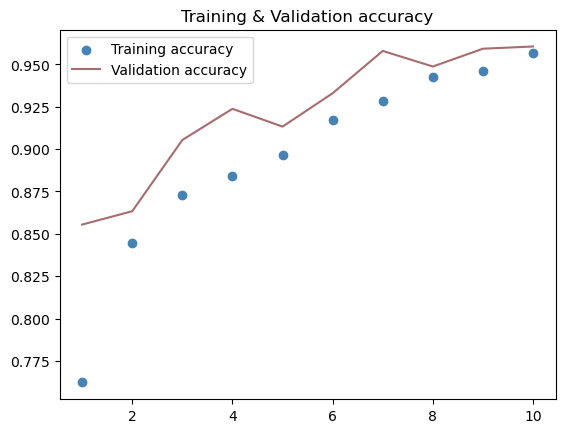

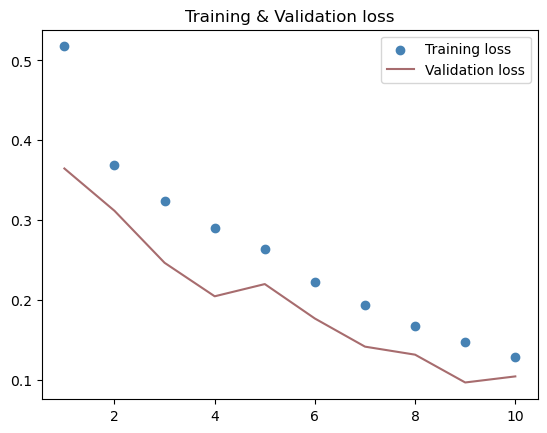

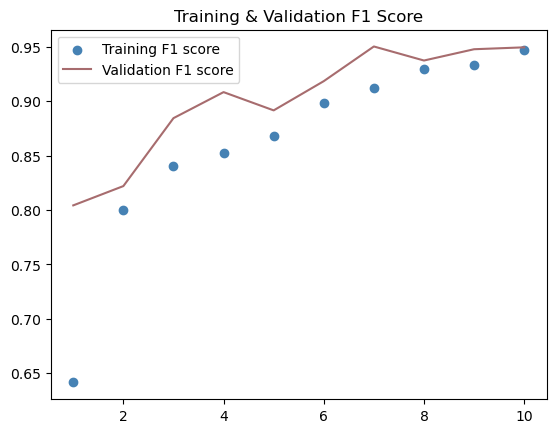

<Figure size 640x480 with 0 Axes>

In [225]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
f1_score = history.history['f1_m']
val_f1_score = history.history['val_f1_m']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy)+1)
plt.scatter(epochs, accuracy, c=mycolors['blue'], marker='o', label = 'Training accuracy')
plt.plot(epochs, val_accuracy, c=mycolors['red'], label = 'Validation accuracy')
plt.title('Training & Validation accuracy')
plt.legend()
plt.figure();
plt.scatter(epochs, loss, c=mycolors['blue'], marker='o', label = 'Training loss')
plt.plot(epochs, val_loss, c=mycolors['red'], label = 'Validation loss')
plt.title('Training & Validation loss')
plt.legend()
plt.figure();
plt.scatter(epochs, f1_score, c=mycolors['blue'], marker='o', label = 'Training F1 score')
plt.plot(epochs, val_f1_score, c=mycolors['red'], label = 'Validation F1 score')
plt.title('Training & Validation F1 Score')
plt.legend()
plt.figure();

#### Word embedding model with using pretrained embedding vector

In [229]:
# Parse GloVe embedding vector
glove_file_path = Path.home() /'Desktop/RNN/glove.6B.100d.txt'
embeddings_index={}

# Get words and their coefs
with open(glove_file_path) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        # Turn coefs as 1D float array
        coefs=np.fromstring(coefs, 'f', sep=' ')
        embeddings_index[word] = coefs

In [231]:
# Prepare GloVe embedding matrix
embedding_dim=100
# Get the vocabulary created by TextVectorization
vocab = text_vectorization.get_vocabulary()
word_index = dict(zip(vocab, range(len(vocab))))
# Create an empty matrix to store each word's vector
embedding_matrix=np.zeros((max_tokens, embedding_dim))

for word, i in word_index.items():
    if i < max_tokens:
        # Get word's vector from GloVe, if not existed, return None
        embedding_vector=embeddings_index.get(word)
    if embedding_vector is not None:
        # Store the vector, if None, the vector is all zeros
        embedding_matrix[i]=embedding_vector


In [234]:
# Load GloVe vectors into embedding layers
embedding_layer=keras.layers.Embedding(
    max_tokens,
    embedding_dim,
    # Load pretrained embedded vector
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    # Set False to avoid destorying the trained features
    trainable=False,
    mask_zero=True
)

In [235]:
inputs=keras.Input(shape=(None,), dtype='int64')
embedded=embedding_layer(inputs)
x=keras.layers.Bidirectional(keras.layers.LSTM(32))(embedded)
x=keras.layers.Dropout(.5)(x)
outputs=keras.layers.Dense(1, activation='sigmoid')(x)
model=keras.Model(inputs, outputs)
model.compile(
    optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=['accuracy',f1_m, precision_m, recall_m]
)
print(model.summary())

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_30 (InputLayer)       [(None, None)]            0         
                                                                 
 embedding_6 (Embedding)     (None, None, 100)         1500000   
                                                                 
 bidirectional_7 (Bidirectio  (None, 64)               34048     
 nal)                                                            
                                                                 
 dropout_29 (Dropout)        (None, 64)                0         
                                                                 
 dense_51 (Dense)            (None, 1)                 65        
                                                                 
Total params: 1,534,113
Trainable params: 34,113
Non-trainable params: 1,500,000
____________________________________________

In [236]:
callbacks = [
    keras.callbacks.ModelCheckpoint('glove_embedding_sequence_model.keras_', save_best_only=True)
]
history=model.fit(
    int_train_dataset,
    epochs=10,
    validation_data=int_val_dataset,
    callbacks=callbacks
)

Epoch 1/10
189/191 [============================>.] - ETA: 0s - loss: 0.5098 - accuracy: 0.7598 - f1_m: 0.6963 - precision_m: 0.7534 - recall_m: 0.6708

INFO:tensorflow:Assets written to: glove_embedding_sequence_model.keras_\assets


INFO:tensorflow:Assets written to: glove_embedding_sequence_model.keras_\assets


191/191 [==============================] - 25s 103ms/step - loss: 0.5097 - accuracy: 0.7599 - f1_m: 0.6960 - precision_m: 0.7527 - recall_m: 0.6706 - val_loss: 0.4213 - val_accuracy: 0.8068 - val_f1_m: 0.7616 - val_precision_m: 0.8025 - val_recall_m: 0.7362
Epoch 2/10
191/191 [==============================] - 3s 16ms/step - loss: 0.4477 - accuracy: 0.8013 - f1_m: 0.7457 - precision_m: 0.8161 - recall_m: 0.7058 - val_loss: 0.4378 - val_accuracy: 0.8095 - val_f1_m: 0.7543 - val_precision_m: 0.7622 - val_recall_m: 0.7691
Epoch 3/10
191/191 [==============================] - 3s 16ms/step - loss: 0.4256 - accuracy: 0.8161 - f1_m: 0.7642 - precision_m: 0.8397 - recall_m: 0.7200 - val_loss: 0.4346 - val_accuracy: 0.8003 - val_f1_m: 0.7541 - val_precision_m: 0.8372 - val_recall_m: 0.6963
Epoch 4/10
188/191 [============================>.] - ETA: 0s - loss: 0.4191 - accuracy: 0.8172 - f1_m: 0.7619 - precision_m: 0.8387 - recall_m: 0.7142

INFO:tensorflow:Assets written to: glove_embedding_sequence_model.keras_\assets


INFO:tensorflow:Assets written to: glove_embedding_sequence_model.keras_\assets


191/191 [==============================] - 18s 96ms/step - loss: 0.4174 - accuracy: 0.8177 - f1_m: 0.7631 - precision_m: 0.8383 - recall_m: 0.7165 - val_loss: 0.3818 - val_accuracy: 0.8318 - val_f1_m: 0.7756 - val_precision_m: 0.8946 - val_recall_m: 0.6970
Epoch 5/10
188/191 [============================>.] - ETA: 0s - loss: 0.4125 - accuracy: 0.8187 - f1_m: 0.7658 - precision_m: 0.8472 - recall_m: 0.7160

INFO:tensorflow:Assets written to: glove_embedding_sequence_model.keras_\assets


INFO:tensorflow:Assets written to: glove_embedding_sequence_model.keras_\assets


191/191 [==============================] - 19s 100ms/step - loss: 0.4135 - accuracy: 0.8181 - f1_m: 0.7654 - precision_m: 0.8465 - recall_m: 0.7158 - val_loss: 0.3710 - val_accuracy: 0.8449 - val_f1_m: 0.8132 - val_precision_m: 0.8776 - val_recall_m: 0.7694
Epoch 6/10
191/191 [==============================] - 3s 17ms/step - loss: 0.3960 - accuracy: 0.8333 - f1_m: 0.7828 - precision_m: 0.8618 - recall_m: 0.7322 - val_loss: 0.3916 - val_accuracy: 0.8331 - val_f1_m: 0.7682 - val_precision_m: 0.9348 - val_recall_m: 0.6674
Epoch 7/10
190/191 [============================>.] - ETA: 0s - loss: 0.3919 - accuracy: 0.8314 - f1_m: 0.7768 - precision_m: 0.8620 - recall_m: 0.7241

INFO:tensorflow:Assets written to: glove_embedding_sequence_model.keras_\assets


INFO:tensorflow:Assets written to: glove_embedding_sequence_model.keras_\assets


191/191 [==============================] - 18s 96ms/step - loss: 0.3919 - accuracy: 0.8312 - f1_m: 0.7757 - precision_m: 0.8601 - recall_m: 0.7238 - val_loss: 0.3651 - val_accuracy: 0.8568 - val_f1_m: 0.8151 - val_precision_m: 0.8672 - val_recall_m: 0.7764
Epoch 8/10
191/191 [==============================] - 3s 17ms/step - loss: 0.3804 - accuracy: 0.8373 - f1_m: 0.7825 - precision_m: 0.8719 - recall_m: 0.7244 - val_loss: 0.3904 - val_accuracy: 0.8318 - val_f1_m: 0.7475 - val_precision_m: 0.9175 - val_recall_m: 0.6394
Epoch 9/10
190/191 [============================>.] - ETA: 0s - loss: 0.3654 - accuracy: 0.8457 - f1_m: 0.8008 - precision_m: 0.8801 - recall_m: 0.7485

INFO:tensorflow:Assets written to: glove_embedding_sequence_model.keras_\assets


INFO:tensorflow:Assets written to: glove_embedding_sequence_model.keras_\assets


191/191 [==============================] - 19s 102ms/step - loss: 0.3650 - accuracy: 0.8458 - f1_m: 0.8013 - precision_m: 0.8807 - recall_m: 0.7487 - val_loss: 0.3119 - val_accuracy: 0.8699 - val_f1_m: 0.8348 - val_precision_m: 0.8947 - val_recall_m: 0.7926
Epoch 10/10
191/191 [==============================] - 3s 16ms/step - loss: 0.3622 - accuracy: 0.8419 - f1_m: 0.7959 - precision_m: 0.8777 - recall_m: 0.7423 - val_loss: 0.3347 - val_accuracy: 0.8594 - val_f1_m: 0.8277 - val_precision_m: 0.9091 - val_recall_m: 0.7715


In [237]:
test_model = keras.models.load_model('glove_embedding_sequence_model.keras_', compile=False) #custom_objects={'f1_m':f1_m, 'precison_m' : precision_m, 'recall_m' : recall_m})
test_model.compile(
        optimizer='rmsprop',
        loss='binary_crossentropy', # keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy',f1_m, precision_m, recall_m]
)

test_loss, test_acc, test_f1, test_precision, test_recall = test_model.evaluate(int_test_dataset)
print(f"Test accuracy: {test_acc:.3f}")
print(f"Test F1 score: {test_f1:.3f}")

24/24 [==============================] - 3s 8ms/step - loss: 0.3286 - accuracy: 0.8701 - f1_m: 0.8313 - precision_m: 0.8704 - recall_m: 0.8082
Test accuracy: 0.870
Test F1 score: 0.831


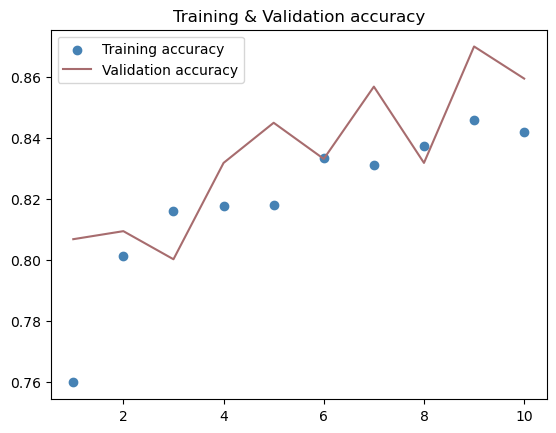

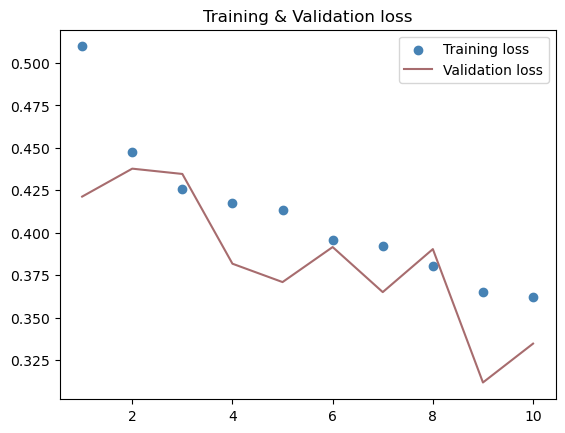

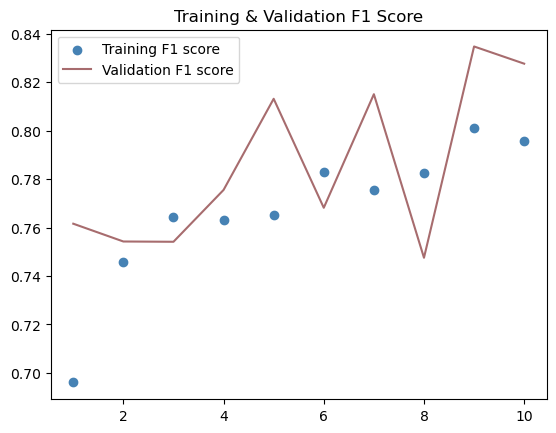

<Figure size 640x480 with 0 Axes>

In [238]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
f1_score = history.history['f1_m']
val_f1_score = history.history['val_f1_m']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy)+1)
plt.scatter(epochs, accuracy, c=mycolors['blue'], marker='o', label = 'Training accuracy')
plt.plot(epochs, val_accuracy, c=mycolors['red'], label = 'Validation accuracy')
plt.title('Training & Validation accuracy')
plt.legend()
plt.figure();
plt.scatter(epochs, loss, c=mycolors['blue'], marker='o', label = 'Training loss')
plt.plot(epochs, val_loss, c=mycolors['red'], label = 'Validation loss')
plt.title('Training & Validation loss')
plt.legend()
plt.figure();
plt.scatter(epochs, f1_score, c=mycolors['blue'], marker='o', label = 'Training F1 score')
plt.plot(epochs, val_f1_score, c=mycolors['red'], label = 'Validation F1 score')
plt.title('Training & Validation F1 Score')
plt.legend()
plt.figure();

### Data split

## Last